# Fabrication-Aware Simulation: Two Coupled Ring Resonator Filter

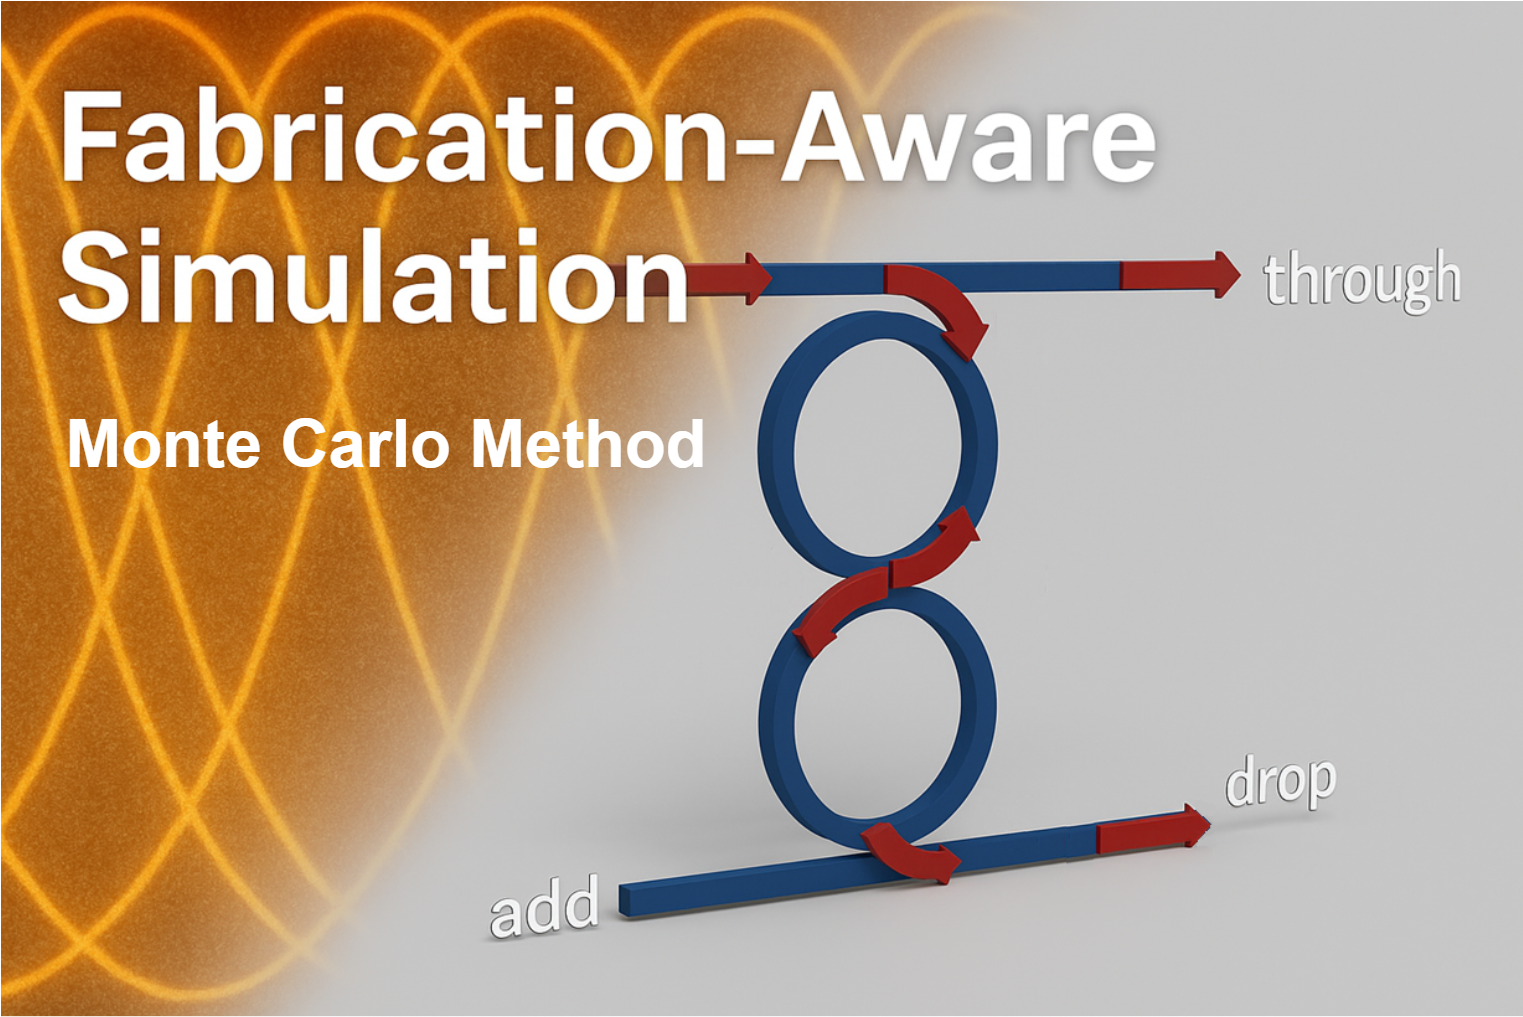


In this notebook we demonstrate how we can perform fabrication-aware simulations in PhotonForge by modeling a 2-ring coupled resonator filter and running a Monte Carlo analysis on key process-variation parameters. We focus on variations in the **coupler gap**, **silicon wafer thickness**, and **sidewall angle**, then visualize their impact on spectral response.

We use the couple mode theory presented in [1] for the filter design. 

**References**
1. Little, Brent E., et al. "Microring resonator channel dropping filters." *Journal of lightwave technology* 1997 15 (6), 998-1005, doi: [10.1109/50.588673](https://doi.org/10.1109/50.588673).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import tidy3d as td
from scipy.signal import find_peaks
import pandas as pd


# Reduce non-critical Tidy3D logs to keep the notebook output clean
td.config.logging_level = "ERROR"

## Setting Up Technology and Simulation Defaults

Here we load and configure the default technology, mesh, and wavelength settings that will be used throughout the notebook.  
We start from PhotonForge’s **basic technology**, set it as the default, and define a **bending radius** and **port specification**. We also fix a **mesh refinement level** and specify the **simulation wavelength range** around 1.55 µm — the telecom C-band region where most silicon photonic devices operate. 




In [2]:
# Load the basic technology
tech = pf.basic_technology()

# Set this as the default technology for all subsequent components
pf.config.default_technology = tech

# Extract the standard single-mode strip waveguide port specification
port_spec = tech.ports["Strip"]

# Set some default parameters for all components (e.g., bend radius)
pf.config.default_kwargs = {
    "radius": 5,  # bend radius in microns
    "port_spec": port_spec,
}

# Define the default mesh refinement level
pf.config.default_mesh_refinement = 15

# Define the wavelength range for optical simulations [µm]
wavelengths = np.linspace(1.543, 1.557, 401)

## Parametric 2-Ring Filter Construction

We define a parametric function to build a **two coupled ring resonator (2-RR) filter** using PhotonForge primitives. The function instantiates two types of couplers — a **bus-to-ring coupler** and a **ring-to-ring coupler** — and then stitches them with a **netlist** that sets up instances, interconnects ports, and exposes the device I/O.

**What we parameterize**
- **coupling_length**: the straight interaction length in the couplers, controlling the coupling coefficient.
- **bus_coupling_distance**: the nominal gap between the bus waveguide and each ring.
- **ring_coupling_distance**: the nominal gap between the two rings in the inter-ring coupler.

**Netlist assembly**
We instantiate:
- Two bus couplers (`bus_coupler0`, `bus_coupler1`)
- One ring-to-ring coupler (`ring_coupler0`)

We then connect their ports to form the 2-RR filter topology and publish four external ports.

Finally, we build the component from the netlist and create a default instance for quick visualization.

### Flat-Top (Maximally-Flat) Design Condition

To achieve a **flat-top (maximally-flat)** passband in the **two-ring add–drop filter** (with identical rings), we choose the **coupling gaps** such that the **bus-to-ring** and **ring-to-ring** coupling coefficients satisfy the synthesis relation derived in [1]:

$\kappa_{\text{int}}
= \frac{1}{2} \kappa_{\text{ext}}^2$

where:
- $\kappa_{\text{ext}}$ — bus-to-ring (external) power coupling coefficient ($\kappa_{\text{ext}} \approx 0.4$ in our design) 
- $\kappa_{\text{int}}$ — ring-to-ring (internal) power coupling coefficient ($\kappa_{\text{int}} \approx 0.08$ in our design) 

This condition ensures a **maximally-flat spectral response** by properly balancing external and internal coupling strengths. 


In [3]:
@pf.parametric_component
def create_two_rr_filter(
    *,
    coupling_length: float = 13.5,
    bus_coupling_distance: float = 0.7,
    ring_coupling_distance: float = 0.81,
) -> pf.Component:
    """
    Build a 2-ring (2RR) filter from parametric couplers and return the component.
    """
    # Parametric subcomponents
    bus_to_ring = pf.parametric.dual_ring_coupler(
        coupling_distance=bus_coupling_distance,
        coupling_length=coupling_length,
        tidy3d_model_kwargs={
            "verbose": False,
            "port_symmetries": [
                ("P1", "P0", "P3", "P2"),
                ("P2", "P3", "P0", "P1"),
                ("P3", "P2", "P1", "P0"),
            ],
        },
    )

    ring_to_ring = bus_to_ring.copy().update(coupling_distance=ring_coupling_distance)

    # Netlist for assembling the 2RR resonator
    netlist_2RR = {
        "name": "filter",
        "instances": {
            "bus_coupler0": bus_to_ring,
            "bus_coupler1": bus_to_ring,
            "ring_coupler0": ring_to_ring,
        },
        "connections": [
            (("ring_coupler0", "P0"), ("bus_coupler0", "P1")),
            (("bus_coupler1", "P3"), ("ring_coupler0", "P1")),
        ],
        "ports": [
            ("bus_coupler0", "P0"),  
            ("bus_coupler1", "P2"),  
            ("bus_coupler0", "P2"),  
            ("bus_coupler1", "P0"),  
        ],
        "models": [pf.CircuitModel()],
    }

    two_rr = pf.component_from_netlist(netlist_2RR)
    return two_rr


two_rr = create_two_rr_filter()
two_rr


We now compute and visualize the spectral characteristics of the designed 2-RR filter.  

Loading cached simulation from /home/amin/.tidy3d/pf_cache/JOE/ms_info-XIP56TS7ZEUQSBBJ7Z7EZAFHCYKSGN6ODWUHSR4NIBHTT4VGYP2Q.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/QUM/ms_info-Z47PPQEWJ3A5HIDN4R7I4RFVVSWZWYVVDSUHGZB7DBJTMHRSVTCA.json.
Progress: 100% 


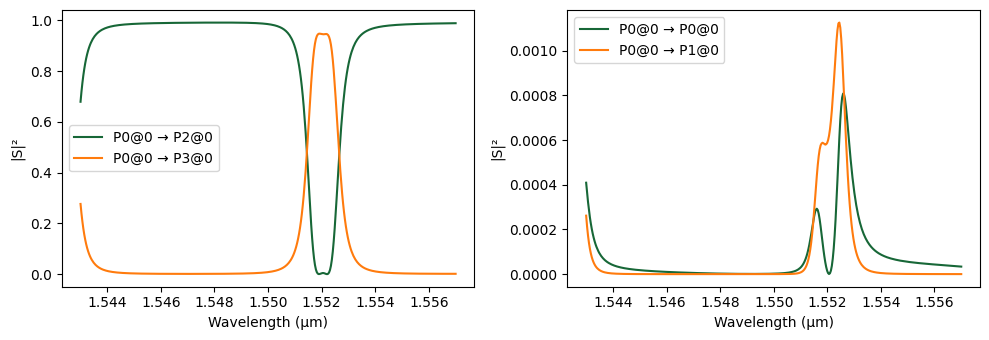

In [4]:
# Compute the scattering matrix (S-matrix) of the 2RR filter across wavelengths
s_matrix_2rr = two_rr.s_matrix(frequencies=pf.C_0 / wavelengths)

# Plot the S-matrix with input from port P0, showing response in dB
_ = pf.plot_s_matrix(s_matrix_2rr, input_ports=["P0"])

## Monte Carlo Analysis

To evaluate fabrication tolerance and yield, we perform a **Monte Carlo simulation** on the 2-RR filter.  
Each sample randomly perturbs selected geometric and material parameters within specified distributions, emulating real-world process variations.

**Parameters under variation**
- **core_thickness (technology)**: silicon layer thickness, mean 0.22 µm with a 3 nm standard deviation  
- **sidewall_angle (technology)**: etched sidewall deviation, uniformly sampled between 0° and 5°  
- **bus_coupling_distance (component)**: coupling gap between bus and ring, mean 0.7 µm with 10 nm σ  
- **ring_coupling_distance (component)**: gap between rings, mean 0.79 µm with 10 nm σ  

We include both **random** and **corner** samples to span statistical variability and worst-case scenarios.  
The resulting dataset contains a list of parameter realizations and their corresponding S-matrices.


In [5]:
# Run a Monte Carlo S-matrix analysis to capture fabrication-induced variations
var, results = pf.monte_carlo.s_matrix(
    two_rr,
    pf.C_0 / wavelengths,
    ("core_thickness", "technology", {"value": 0.22, "stdev": 0.003}),
    ("sidewall_angle", "technology", {"value_range": [0, 5]}),
    ("bus_coupling_distance", two_rr, {"value": 0.7, "stdev": 0.01}),
    ("ring_coupling_distance", two_rr, {"value": 0.81, "stdev": 0.01}),
    random_samples=20,  # number of random samples
    corner_samples=2,  # corner cases (extreme combinations)
    random_seed=0,
    show_progress=True,
)

Starting sample 1 of 22…
Loading cached simulation from /home/amin/.tidy3d/pf_cache/LRU/ms_info-JSKJTDXWFBBR32NYCYBPQ5JJ7Y66JDWBZJ4HSSL37ILDARRWEIJQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/BYE/ms_info-SXKDZJTEDUITOH6O6SEDSADVD6O2ZP6U5Y7ZDS45XLXBE76G3YSQ.json.
Starting sample 2 of 22…
Loading cached simulation from /home/amin/.tidy3d/pf_cache/PSC/ms_info-36ARABZQI5JRQBP2UCCWGG2XYYIMHNERKYANB4U4V4I3Y72OR4GQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/MJT/ms_info-A4OS4MQNDWMFKKCYON6QG4LKFQCN65GG2MK4KRSVFBOHBMXZAJUQ.json.
Starting sample 3 of 22…
Loading cached simulation from /home/amin/.tidy3d/pf_cache/Y6J/ms_info-QRQ72JYYJ6UNX3R25UM7MABILVFD5E26GKV5LT3KT24KS7BL7XOQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/TXD/ms_info-UR25HAJ6Y4JTLM452HME54CXNUZ4EZDQPTAGLVHM6YKUGU42KBEQ.json.
Starting sample 4 of 22…
Loading cached simulation from /home/amin/.tidy3d/pf_cache/53Z/ms_info-TA4QH27XK5VPAMQI4U3JHLNJBD6HAIJ4PDT2AD52EIL7ORQYH

We now plot the **transmission spectra** from port P0 (input) to port P3 (drop port) for all Monte Carlo samples.  
Each curve represents one possible fabricated instance of the 2-RR filter, allowing us to observe the spread in resonance wavelength and insertion loss due to process variations.

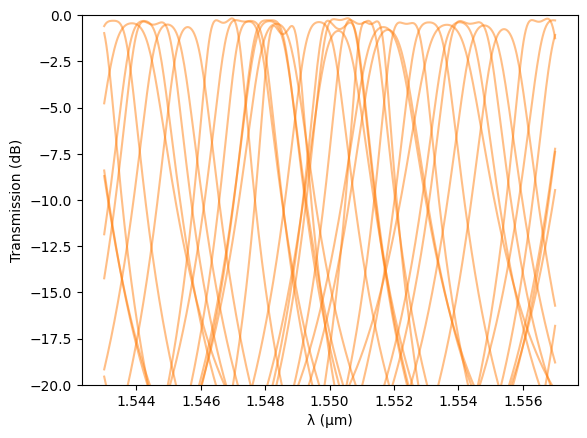

In [6]:
fig, ax = plt.subplots(1, 1)

for *_, s_matrix in results:
    ax.plot(
        s_matrix.wavelengths,
        20 * np.log10(np.abs(s_matrix[("P0@0", "P3@0")])),
        alpha=0.5,
        color="tab:orange",
    )

_ = ax.set(ylim=(-20, 0), xlabel="λ (µm)", ylabel="Transmission (dB)")

### Discussion of Fabrication-Aware Results

The Monte Carlo simulation shows that fabrication variations can significantly impact the **spectral response** of the 2-RR filter:

- **Resonance wavelength drift:**  
  The resonance positions vary substantially between samples, indicating that small deviations in silicon thickness, sidewall angle, or coupling gaps lead to noticeable phase shifts and effective index changes.  
  This explains why **thermal tuning** (via integrated heaters) is almost always required in fabricated ring filters to fine-tune or align the resonance wavelengths post-fabrication.

- **Insertion loss variation:**  
  The simulated **through-port transmission** fluctuates between approximately **0.3 dB and 1.0 dB**, demonstrating that while loss performance changes slightly, the filter remains **fairly robust** to process deviations in this respect.  

Overall, the analysis illustrates how PhotonForge’s fabrication-aware modeling can predict both resonance misalignment and performance spread, allowing designers to anticipate tuning requirements and optimize yield.


## Correlation Analysis
Monte Carlo analysis allows for the extraction of correlations between a device's response and its input variables. This section demonstrates the correlation analysis process. **Critically, accurate results with four input variables require hundreds of data points**. The findings presented here are, therefore, purely illustrative and not statistically significant.

### Feature extraction
In this section we extract three filter features from each simulated S-matrix so we can study their correlation with fabrication variables. We target the resonance closest to a **reference wavelength** $\lambda_0$ (default $1.55 \mu$m) and compute:

- **Center wavelength** $\lambda_c$: the midpoint between the two 3-dB crossing wavelengths around the chosen resonance.
- **Insertion loss** IL (in dB): transmission value at the center wavelength.
- **3-dB bandwidth** $\Delta\lambda_{3,\text{dB}}$: difference between the right and left 3-dB crossing wavelengths.



In [7]:
def extract_filter_features(s_matrix, target_wavelength=1.55):
    """
    Extracts key features (insertion loss, center wavelength, bandwidth)
    from an optical filter's S-matrix data.

    This function identifies the resonance dip closest to a target wavelength
    and calculates its characteristics.

    Args:
        s_matrix: The S-matrix object from the simulation. 
        target_wavelength (float): The wavelength (in µm) around which to
                                   search for the primary resonance.
                                   Defaults to 1.55 µm.

    Returns:
        dict: A dictionary containing the calculated 'center_wavelength',
              'insertion_loss' (in dB), and 'bandwidth' (in µm).
              Returns None if no resonance is found.
    """
    wavelengths = s_matrix.wavelengths
    # Calculate transmission in dB
    transmission_db = 20 * np.log10(np.abs(s_matrix[("P0@0", "P3@0")]))

    # The 'prominence' parameter helps ignore minor ripples and noise.
    peak_indices, _ = find_peaks(transmission_db, prominence=1)

    if peak_indices.size == 0:
        print("Warning: No resonance peaks found.")
        return None

    # Find the peak/resonance closest to the target wavelength
    resonant_wavelengths = wavelengths[peak_indices]
    closest_peak_index = peak_indices[np.argmin(np.abs(resonant_wavelengths - target_wavelength))]

    # --- 1. Calculate Maximum Transmission Wavelength and Insertion Loss ---
    max_wavelength = wavelengths[closest_peak_index]
    insertion_loss = transmission_db[closest_peak_index]

    # --- 2. Calculate 3-dB Bandwidth ---
    # The 3-dB level is 3 dB below the maximum transmission value (the IL)
    three_db_level = insertion_loss - 3

    # Find where the transmission crosses the 3-dB level on both sides of the resonance
    # Split the transmission data at the resonance point
    left_side = transmission_db[:closest_peak_index]
    right_side = transmission_db[closest_peak_index:]

    # Find the indices where the transmission is greater than the 3-dB level
    left_indices_below_3db = np.where(left_side < three_db_level)[0]
    right_indices_below_3db = np.where(right_side < three_db_level)[0]

    if left_indices_below_3db.size == 0 or right_indices_below_3db.size == 0:
         bandwidth = np.nan # Use NaN for cases where bandwidth can't be found
    else:
        # Get the points just before and after the crossing
        left_cross_idx = left_indices_below_3db[-1]
        right_cross_idx = right_indices_below_3db[0] + closest_peak_index

        # Interpolate to find the exact wavelength at the 3dB crossing for better accuracy
        w_left = np.interp(three_db_level,
                           [transmission_db[left_cross_idx], transmission_db[left_cross_idx + 1]],
                           [wavelengths[left_cross_idx], wavelengths[left_cross_idx + 1]])

        w_right = np.interp(three_db_level,
                            [transmission_db[right_cross_idx - 1], transmission_db[right_cross_idx]],
                            [wavelengths[right_cross_idx - 1], wavelengths[right_cross_idx]])

        # Compute bandwidth and center wavelength from crossings
        bandwidth = w_right - w_left
        center_wavelength = (w_right + w_left)/2
        insertion_loss = transmission_db[(left_cross_idx+right_cross_idx)//2]

    return {
        "center_wavelength": center_wavelength,
        "insertion_loss": insertion_loss,
        "bandwidth": bandwidth,
    }
    

### Correlation Matrix

In this section we take the Monte Carlo results and visually explore how each **fabrication parameter** affects the main **filter features**.  
We generate a **grid of scatter plots**, one for each input–output pair, annotated with the **Pearson correlation coefficient (R)**.

**Interpretation**
- **R ≈ +1:** Strong positive correlation — as the fabrication parameter increases, the feature value increases.  
- **R ≈ -1:** Strong negative correlation — the feature decreases as the parameter increases.  
- **R ≈ 0:** Weak or no linear correlation.

This visualization allows us to directly identify which fabrication tolerances most strongly impact spectral behavior such as resonance shift, insertion loss, or bandwidth broadening.

**Important note**: The correlation results shown here are intended for demonstration only and are **not statistically valid** because of small number of data points.

Processing simulation results...
Successfully processed 22 data points.

--- Data Head ---
   sidewall_angle  core_thickness  ring_coupling_distance  \
0        5.000000        0.225880                0.829600   
1        0.000000        0.214120                0.790400   
2        4.517759        0.218700                0.817602   
3        4.244655        0.219547                0.792679   
4        2.785838        0.219909                0.808466   

   bus_coupling_distance  center_wavelength_nm  insertion_loss  bandwidth_nm  
0               0.719600           1551.289951       -0.484303      0.990097  
1               0.680400           1553.650351       -0.523616      1.589298  
2               0.699238           1549.683240       -0.377694      1.193520  
3               0.713226           1550.297463       -0.751649      1.435075  
4               0.703479           1548.130114       -0.277430      1.289771  

--- Generating Custom Scatter Plot Grid with Correlation Values ---

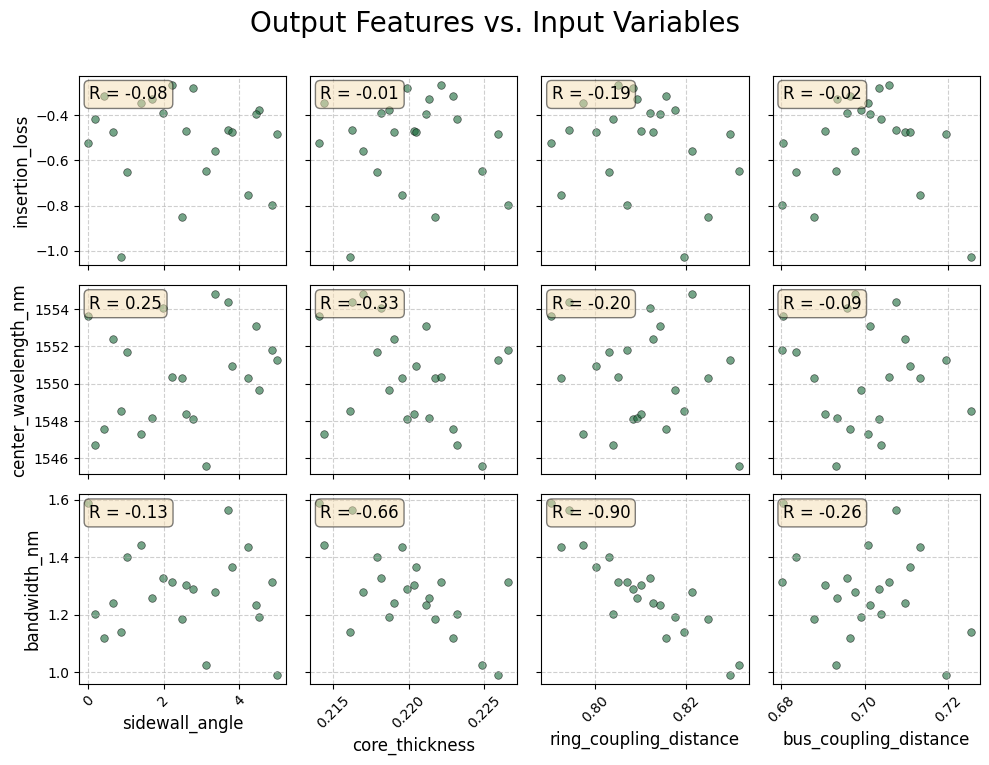

In [8]:

def run_correlation_analysis(variables, simulation_results, target_wavelength=1.55):
    """
    Processes Monte Carlo simulation results to visualize the relationship
    and correlation between each input variable and each output filter feature.

    Args:
        variables (list): The list of RandomVariable objects from the simulation.
        simulation_results (list): The list of result tuples from the simulation.
                                     Each tuple contains the input values and the s_matrix.
        target_wavelength (float): The target wavelength in micrometers.
    """
    data = []
    variable_names = [v.name for v in variables]

    print("Processing simulation results...")
    for result in simulation_results:
        s_matrix = result[-1]
        input_values = result[:-1]
        features = extract_filter_features(s_matrix, target_wavelength=target_wavelength)

        if features:
            run_data = {name: val for name, val in zip(variable_names, input_values)}
            run_data.update(features)
            data.append(run_data)
    
    if not data:
        print("Could not extract features from any simulation run. Aborting.")
        return

    print(f"Successfully processed {len(data)} data points.")
    df = pd.DataFrame(data)
    df['center_wavelength'] *= 1e3
    df['bandwidth'] *= 1e3
    df = df.rename(columns={
        'center_wavelength': 'center_wavelength_nm',
        'bandwidth': 'bandwidth_nm'
    })

    print("\n--- Data Head ---")
    print(df.head())

    output_feature_names = ['insertion_loss', 'center_wavelength_nm', 'bandwidth_nm']

    print("\n--- Generating Custom Scatter Plot Grid with Correlation Values ---")

    n_outputs = len(output_feature_names)
    n_inputs = len(variable_names)

    fig, axes = plt.subplots(n_outputs, n_inputs, figsize=(10, 8), sharex='col', sharey='row')
    
    if n_outputs == 1 or n_inputs == 1:
        axes = np.array(axes).reshape(n_outputs, n_inputs)

    for i, out_feature in enumerate(output_feature_names):
        for j, in_variable in enumerate(variable_names):
            ax = axes[i, j]
            ax.scatter(df[in_variable], df[out_feature], alpha=0.6, s=30, edgecolor='k', linewidth=0.5)
            corr = df[in_variable].corr(df[out_feature])
            corr_text = f"R = {corr:.2f}"
            ax.text(
                0.05, 0.95, corr_text,
                transform=ax.transAxes,  
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.5)
            )
            if j == 0:
                ax.set_ylabel(out_feature, fontsize=12)
            if i == n_outputs - 1:
                ax.set_xlabel(in_variable, fontsize=12)
            
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle('Output Features vs. Input Variables', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

run_correlation_analysis(var, results)